In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [11]:
import kagglehub
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'butterfly-image-classification' dataset.
Path to dataset files: /kaggle/input/butterfly-image-classification


In [12]:
import shutil, os  #importing python modules: shutil (for copying), os (for interacting with os)
dest_dir = "/content/butterfly_dataset"
if not os.path.exists(dest_dir):
    shutil.copytree(path, dest_dir)
print("Dataset copied to:",dest_dir)

Dataset copied to: /content/butterfly_dataset


In [13]:
train_df=pd.read_csv('butterfly_dataset/Training_set.csv')
test_df=pd.read_csv('butterfly_dataset/Testing_set.csv')

In [14]:
train_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [16]:
train_df['label'].nunique()

75

In [17]:
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [18]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [19]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,  # divides pixel value (0-255) by 255 --> scale them to (0-1)
                                   rotation_range=20,   # randomly rotates images upto +-20
                                   width_shift_range=0.2,   # randomly shifts images horizontally up to 20%
                                   height_shift_range=0.2,   # randomly shifts images vertically up to 20%
                                   shear_range=0.2,   # applies random shearing
                                   zoom_range=0.2,  # randomly zooms in/out up to 20%
                                   horizontal_flip=True)   # randomly flips images horizontally

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'butterfly_dataset/train'
test_dir = 'butterfly_dataset/test'

#resize --> augmentation --> batches --> predict

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(128,128),   # every image will be resized to 128 * 128 pixels
    batch_size=32,   # it will produce batches of 32 images at a time
    class_mode='categorical'  # multi-class classification
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(   #.flow_from_dataframe --> method of ImageDataGenerator
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,   # no labels in the test dataset
    target_size=(128,128),
    batch_size=32,
    class_mode=None, # test data has no labels
    shuffle=False
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

unique_class=train_df['label'].nunique()

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),  # (height, width, channels: 1--> grey scale, 3--> rgb)
    MaxPooling2D(2,2),  # for each 2*2 block--> takes the maximum value (the strongest feature)

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  #ignores 50% of neurons while training to prevent overfitting
    Dense(unique_class, activation='softmax')  #75 neurons --> 75 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #categorical_crossentropy --> loss function for classification
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,314,315 (12.64 MB)

 Trainable params: 3,314,315 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      # metric to monitor
    patience=5,              # number of epochs to wait before stopping after no improvement
    restore_best_weights=True  # restore model weights from the epoch with the best value of the monitored metric
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]   # add the callback here
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - accuracy: 0.0117 - loss: 4.3300 - val_accuracy: 0.0362 - val_loss: 4.0801
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.0386 - loss: 4.0385 - val_accuracy: 0.1192 - val_loss: 3.6309
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 191ms/step - accuracy: 0.0827 - loss: 3.6499 - val_accuracy: 0.1615 - val_loss: 3.2347
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.1442 - loss: 3.2943 - val_accuracy: 0.2615 - val_loss: 2.9959
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 190ms/step - accuracy: 0.2087 - loss: 2.9861 - val_accuracy: 0.3169 - val_loss: 2.5671
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.2459 - loss: 2.7800 - val_accuracy: 0.3446 - val_loss: 2.4195
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 190ms/step - accuracy: 0.2892 - loss: 2.6165 - val_accuracy: 0.3869 - val_loss: 2.2238
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - accuracy: 0.3173 - loss: 2

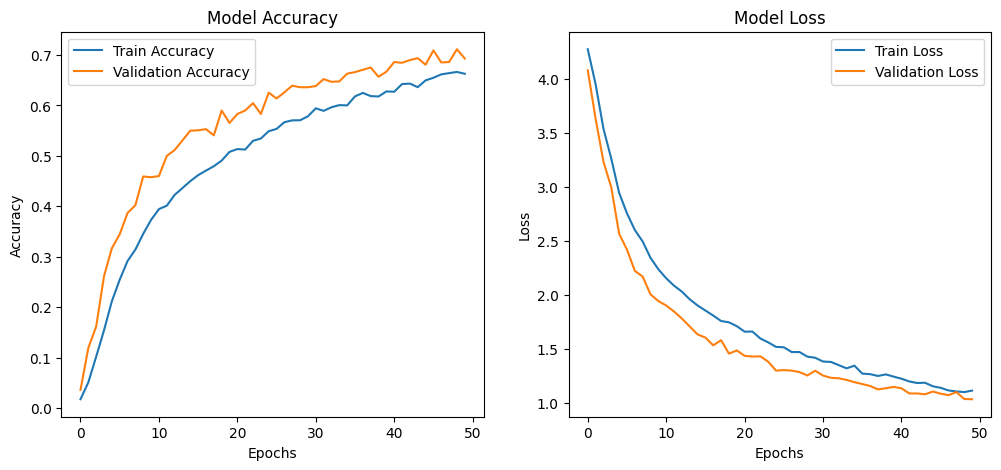

In [23]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
loss, acc = model.evaluate(val_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.6995 - loss: 1.0995
Test Accuracy: 70.08%


In [25]:
model.save("butterfly_classifier.h5")  # .h5 --> file format used to store large amounts of numerical data efficiently
print("Model saved as butterfly_classifier.h5")

Model saved as butterfly_classifier.h5


In [26]:
from tensorflow.keras.models import load_model
from google.colab import files

model = load_model("butterfly_classifier.h5")

uploaded = files.upload()

# swaps the key-value pair (inorder to return the class name not label)
class_labels = {v:k for k,v in train_gen.class_indices.items()}  # keys --> class names, values --> integer labels

for fn in uploaded.keys():
    img = image.load_img(fn, target_size=(128,128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # expands the dimensions like (batch_size,height,width,channels)

    prediction = model.predict(img_array)
    pred_label = class_labels[np.argmax(prediction)]
    print(f"Prediction for {fn}: {pred_label}")

Saving PEACOCK.jpg to PEACOCK.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Prediction for PEACOCK.jpg: PEACOCK


In [27]:
from google.colab import files
files.download("butterfly_classifier.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import json

class_labels = {v: k for k, v in train_gen.class_indices.items()}

with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)

from google.colab import files
files.download("class_labels.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>